# Interpretabilidad de extremo a extremo: del clasificador a la conectividad

**Objetivo.** Explicamos cómo la decisión del clasificador (AD vs. CN) se descompone en (i) variables latentes del VAE, (ii) contribuciones SHAP por característica, y (iii) **saliencia** en el **espacio de conectividad** entre ROIs $i,j$.

**Datos.** Para cada sujeto $n$ tenemos un tensor $X_n \in \mathbb{R}^{C \times R \times R}$, con $C$ canales de conectividad y $R$ ROIs. Cada canal es una matriz simétrica con diagonal nula. Preprocesamos fuera de la diagonal.

**Encoder VAE.** El encoder $E_\theta$ mapea $X_n \mapsto (\mu_n, \log\sigma^2_n)$, con $\mu_n \in \mathbb{R}^{d}$ el vector latente (usado como *features*). En notación compacta $\mu_n = \mu_\theta(X_n)$.

**Clasificador.** Construimos el vector de *features* $z_n = [\mu_n; \text{metadata}_n]$ y entrenamos un clasificador $f$ para $y_n \in \{0,1\}$ (CN/AD). El *pipeline* (one-hot, escalado, selección) queda fijado tras el *fit* y se reaplica a test.


In [1]:
  !python interpretar_fold_gemini_pro.py saliency \
    --run_dir ./resultados67 --fold 1 --clf gb \
    --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz \
    --metadata_path /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv \
    --roi_annotation_path /home/diego/Escritorio/limpio/roi_info_master.csv \
    --channels_to_use 1 2 4 5 \
    --latent_dim 48 \
    --latent_features_type mu \
    --metadata_features Age Sex Manufacturer \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.25 \
    --use_layernorm_vae_fc \
    --intermediate_fc_dim_vae half \
    --vae_final_activation linear \
    --gn_num_groups 16 \
    --saliency_method integrated_gradients \
    --ig_n_steps 100

[INFO] [SALIENCY] fold=1 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx    weight  importance           feature
         28  0.184933    0.000214 latent__latent_28
          8 -0.135120   -0.000157  latent__latent_8
         46  0.113080    0.000131 latent__latent_46
          5  0.063333    0.000073  latent__latent_5
         33  0.062660    0.000073 latent__latent_33
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando método de saliencia: integrated_gradients
[INFO] [SALIENCY] Ranking de conexiones ANOTADO guardado: resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv
[INFO] Top 20 conexiones anotadas:
      Rank src_AAL3_Name dst_AAL3_Name  Saliency_Score          src_Refined_Network        dst_Refined_Network
3624     

## SHAP del clasificador y vector discriminativo en el espacio latente

Sea $f: \mathbb{R}^{p} \to [0,1]$ la probabilidad para la clase positiva (AD) tras el *preprocessor*. Los valores SHAP $\phi_{n,j}$ satisfacen (aprox.) la descomposición aditiva
$$
f(z_n) \approx \mathbb{E}[f(Z)] \;+\; \sum_{j=1}^{p} \phi_{n,j}.
$$
Restringimos nuestra atención a las **features latentes** $j \in \mathcal{L}\subset\{1,\dots,p\}$, identificadas por el patrón `latent_*` tras el *preprocessor*.

Para obtener un **peso discriminativo latente** estable usamos el contraste AD vs. CN a nivel de SHAP:
$$
\Delta_{\text{SHAP},j} \;=\; \mathbb{E}_{n:\,y_n=1}\,[\phi_{n,j}] \;-\; \mathbb{E}_{n:\,y_n=0}\,[\phi_{n,j}], \quad j\in\mathcal{L}.
$$
Normalizamos por $\ell_1$ para inducir un funcional lineal bien condicionado:
$$
w_j \;=\; \frac{\Delta_{\text{SHAP},j}}{\sum_{k\in\mathcal{L}} \lvert \Delta_{\text{SHAP},k}\rvert}\,,\qquad w\in\mathbb{R}^{d}.
$$
Este $w$ pondera dimensiones latentes de acuerdo con su **diferencia explicativa** entre grupos.


Fold 1 – clf=gb – canales=[1, 2, 4, 5]


,channel_index,channel_name,l1_norm,l1_norm_fraction
0,1,Ch1,5.033197,0.286748
1,2,Ch2,4.388445,0.250015
2,4,Ch4,5.121708,0.291790
3,5,Ch5,3.009366,0.171447


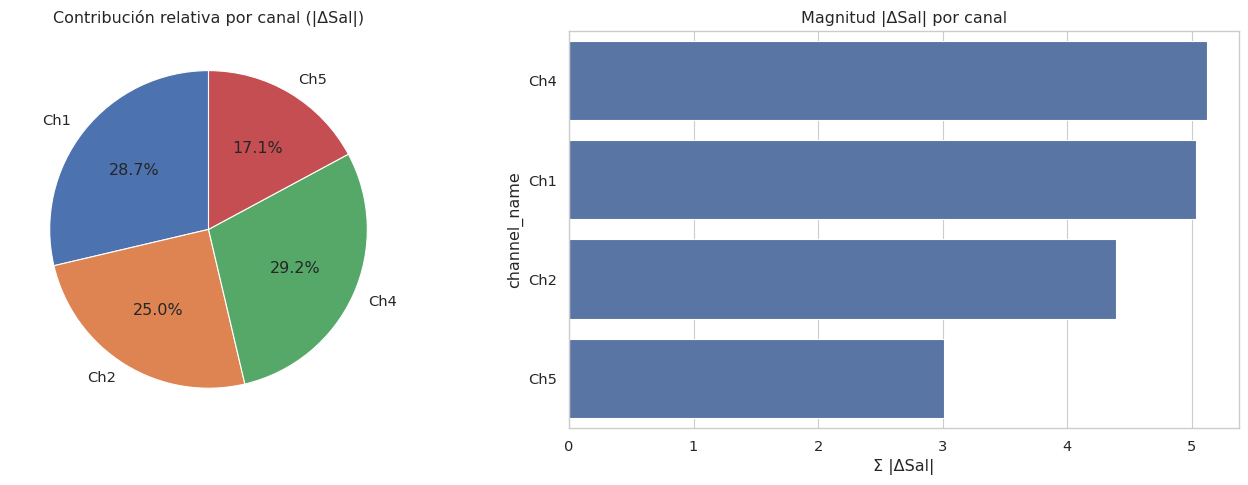

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, json, pathlib
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
ARGS = json.load(open(RUN_DIR / 'run_args_saliency_integrated_gradients_top50.json'))
print(f"Fold {ARGS['fold']} – clf={ARGS['clf']} – canales={ARGS['channels_to_use']}")

dfc = pd.read_csv(RUN_DIR / 'channel_contributions.csv')
display(dfc)

fig, ax = plt.subplots(1,2, figsize=(14,5))
# Pie (fracciones)
ax[0].pie(dfc['l1_norm_fraction'], labels=dfc['channel_name'], autopct='%1.1f%%', startangle=90)
ax[0].set_title('Contribución relativa por canal (|ΔSal|)')
# Barras (magnitud)
sns.barplot(data=dfc.sort_values('l1_norm', ascending=False), x='l1_norm', y='channel_name', ax=ax[1])
ax[1].set_title('Magnitud |ΔSal| por canal'); ax[1].set_xlabel('Σ |ΔSal|')
plt.tight_layout(); plt.show()


## Saliencia en el espacio de conectividad vía Integrated Gradients

Definimos el funcional objetivo sobre la entrada $X$:
$$
F(X) \;=\; w^\top \mu_\theta(X),
$$
donde $\mu_\theta(X)$ es la salida del encoder (vector medio latente). La **atribución IG** de una entrada escalar $X_{c,ij}$ (canal $c$, arista $i\!-\!j$) con *baseline* $X'$ es
$$
\mathrm{IG}_{c,ij}(X;X') \;=\; (X_{c,ij}-X'_{c,ij}) \int_0^1 
\frac{\partial F\!\left(X' + \alpha (X - X')\right)}{\partial X_{c,ij}}\, d\alpha.
$$
Usamos *baseline* nula $X'=0$ (matriz hueca), coherente con la normalización *off-diag* y con la semántica “sin conectividad efectiva” como referencia.

Para un grupo $g\in\{\text{AD},\text{CN}\}$ agregamos **magnitudes** de IG por sujeto y promediamos:
$$
S^{(g)}_{c,ij} \;=\; \mathbb{E}_{n\in g}\left[\,\bigl|\mathrm{IG}_{c,ij}(X_n;0)\bigr|\,\right].
$$
La **saliencia diferencial** es
$$
\Delta S_{c,ij} \;=\; S^{(\text{AD})}_{c,ij} \;-\; S^{(\text{CN})}_{c,ij}.
$$
Signo $>0$ indica mayor relevancia para AD; $<0$ mayor relevancia para CN. Para priorización global, ordenamos aristas por $|\overline{\Delta S}_{ij}|$, donde $\overline{\Delta S}_{ij}=\frac{1}{C}\sum_c \Delta S_{c,ij}$.


## Descomposición por canal

La **contribución por canal** se define como la norma $\ell_1$ acumulada de $\Delta S$:
$$
\mathrm{L1}_c \;=\; \sum_{i<j} \left| \Delta S_{c,ij} \right|,
\qquad
\text{Fracción}_c \;=\; \frac{\mathrm{L1}_c}{\sum_{c'} \mathrm{L1}_{c'}}.
$$
Esto evalúa qué modalidad de conectividad concentra mayor “energía explicativa” diferencial entre grupos.


## Agregación por pares de redes

Agrupamos aristas por par de redes $g,h$ (según anotación de ROIs). Definimos:
$$
M^{\text{abs}}_{g,h} \;=\; \sum_{(i,j)\in (g,h)} \left| \overline{\Delta S}_{ij} \right|,
\qquad
M^{\text{sgn}}_{g,h} \;=\; \sum_{(i,j)\in (g,h)} \overline{\Delta S}_{ij}.
$$
La matriz $M^{\text{abs}}$ refleja “energía” diferencial (independiente del signo). La matriz $M^{\text{sgn}}$ retiene dirección (AD vs. CN). Para visualizar patrones se aplica *clustering* jerárquico sobre $M^{\text{abs}}$ y escala simétrica en $M^{\text{sgn}}$.

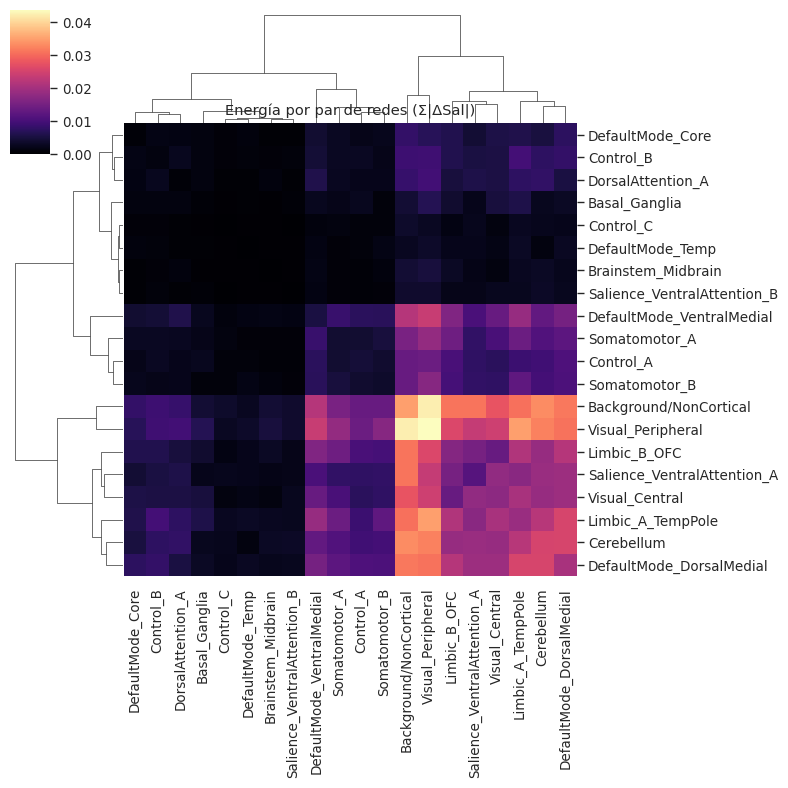

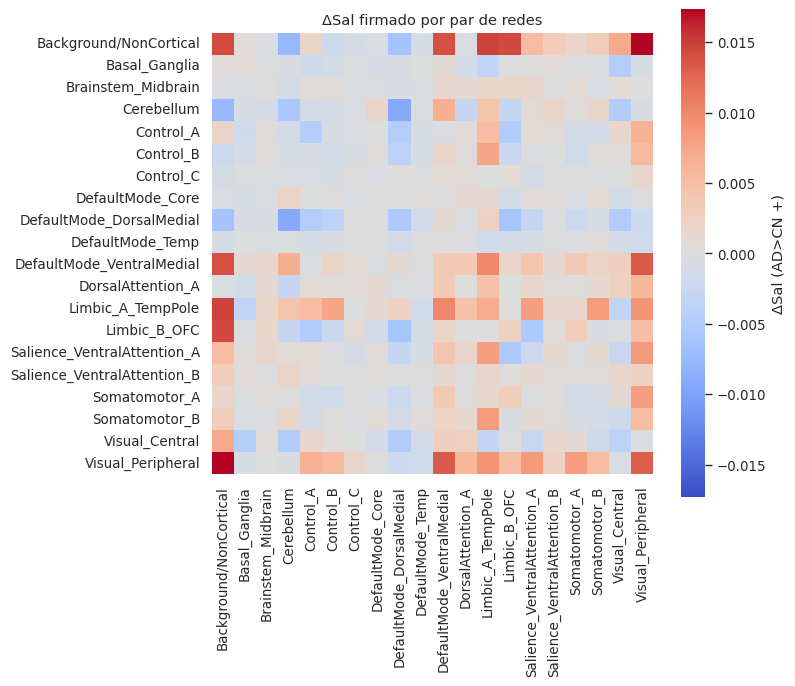

In [3]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, pathlib
sns.set_theme(style="white", context="paper", font_scale=1.1)
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')

Mabs = pd.read_csv(RUN_DIR / 'network_pairs_sumabs_integrated_gradients_top50.csv', index_col=0)
Msig = pd.read_csv(RUN_DIR / 'network_pairs_signed_integrated_gradients_top50.csv', index_col=0)

# Clustering sobre la energía (sum|ΔSal|)
cg = sns.clustermap(Mabs, method='average', metric='euclidean', cmap='magma', figsize=(8,8))
cg.ax_heatmap.set_title('Energía por par de redes (Σ|ΔSal|)')
plt.show()

# Signed con escala simétrica
v = np.nanmax(np.abs(Msig.values))
plt.figure(figsize=(8,7))
sns.heatmap(Msig, cmap='coolwarm', vmin=-v, vmax=v, center=0, square=True, cbar_kws={'label':'ΔSal (AD>CN +)'})
plt.title('ΔSal firmado por par de redes')
plt.tight_layout(); plt.show()


## Enriquecimiento Top-K de pares de redes

Al seleccionar las $K$ aristas con mayor $|\overline{\Delta S}_{ij}|$, contamos ocurrencias por par de redes $p$.
Con:
- población $E$: número total de aristas,
- éxitos en población $M_p$: aristas del par $p$ en todo el grafo,
- tamaño de muestra $N=K$,
- éxitos observados $k_p$ en el Top-K,

evaluamos $P(X \ge k_p)$ para $X\sim \mathrm{Hypergeom}(E, M_p, N)$. Corregimos *p-values* con **Benjamini–Hochberg (BH)** para controlar FDR. Pares con $q<0.05$ se consideran enriquecidos.


In [4]:
import pandas as pd, numpy as np, scipy.stats as st, pathlib

RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
edges = pd.read_csv(RUN_DIR / 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')

net_src = 'src_Refined_Network' if 'src_Refined_Network' in edges.columns else 'src_Yeo17_Network'
net_dst = 'dst_Refined_Network' if 'dst_Refined_Network' in edges.columns else 'dst_Yeo17_Network'

def pair_label(a,b): 
    return '—'.join(sorted([str(a),str(b)]))

edges['pair'] = [pair_label(a,b) for a,b in zip(edges[net_src], edges[net_dst])]

def enrich_K(K):
    top = edges.nsmallest(K, 'Rank')
    E = len(edges)  # población = todas las aristas
    pop_counts = edges['pair'].value_counts()
    k_obs = top['pair'].value_counts()
    out = []
    for p, k in k_obs.items():
        M = pop_counts.get(p,0)  # éxitos en población
        N = K                    # tamaño de muestra
        # P(X >= k) hipergeométrica
        pval = st.hypergeom.sf(k-1, E, M, N)
        out.append((p, k, M, E, N, pval))
    df = pd.DataFrame(out, columns=['pair','k_top','M_pop','E_total','N_top','pval']).sort_values('pval')
    # BH
    m = len(df); ranks = np.arange(1, m+1)
    df['qval_BH'] = (df['pval'] * m / ranks).clip(upper=1).cummin()
    return df

for K in (50,100,200):
    dfk = enrich_K(K)
    dfk.to_csv(RUN_DIR / f'enrichment_network_pairs_top{K}.csv', index=False)
    display(dfk.head(10))


,pair,k_top,M_pop,E_total,N_top,pval,qval_BH
5,DefaultMode_VentralMedial—DorsalAttention_A,2,18,8515,50,0.004869,0.185025
0,DefaultMode_VentralMedial—Visual_Peripheral,3,78,8515,50,0.010643,0.185025
6,DefaultMode_VentralMedial—Limbic_A_TempPole,2,60,8515,50,0.048197,0.185025
18,Brainstem_Midbrain—Cerebellum,1,11,8515,50,0.062764,0.185025
2,Background/NonCortical—Somatomotor_B,2,70,8515,50,0.063390,0.185025
29,DefaultMode_Temp—Visual_Peripheral,1,13,8515,50,0.073754,0.185025
22,Brainstem_Midbrain—Visual_Peripheral,1,13,8515,50,0.073754,0.185025
20,Background/NonCortical—Brainstem_Midbrain,1,14,8515,50,0.079201,0.185025
7,Background/NonCortical—DefaultMode_VentralMedial,2,84,8515,50,0.086941,0.185025
1,Background/NonCortical—Visual_Peripheral,3,182,8515,50,0.090823,0.185025


,pair,k_top,M_pop,E_total,N_top,pval,qval_BH
1,DefaultMode_VentralMedial—Limbic_A_TempPole,5,60,8515,100,0.000662,0.038377
0,Background/NonCortical—Salience_VentralAttenti...,6,112,8515,100,0.001980,0.038377
2,DefaultMode_VentralMedial—Visual_Peripheral,5,78,8515,100,0.002166,0.038377
22,DefaultMode_VentralMedial—DorsalAttention_A,2,18,8515,100,0.018486,0.038377
6,DefaultMode_VentralMedial—Limbic_B_OFC,3,72,8515,100,0.052393,0.038377
3,Limbic_A_TempPole—Visual_Peripheral,4,130,8515,100,0.066453,0.038377
41,Brainstem_Midbrain—DefaultMode_VentralMedial,1,6,8515,100,0.068447,0.038377
7,Background/NonCortical—DefaultMode_VentralMedial,3,84,8515,100,0.075823,0.038377
17,DefaultMode_VentralMedial—Salience_VentralAtte...,2,48,8515,100,0.108859,0.038377
37,Control_C—Limbic_A_TempPole,1,10,8515,100,0.111480,0.038377


,pair,k_top,M_pop,E_total,N_top,pval,qval_BH
0,DefaultMode_VentralMedial—Visual_Peripheral,8,78,8515,200,0.000462,0.042012
4,DefaultMode_VentralMedial—Limbic_A_TempPole,6,60,8515,200,0.002716,0.042012
3,Background/NonCortical—DefaultMode_VentralMedial,7,84,8515,200,0.003491,0.042012
2,Background/NonCortical—Salience_VentralAttenti...,8,112,8515,200,0.004757,0.042012
11,DefaultMode_VentralMedial—Visual_Central,5,54,8515,200,0.008463,0.042012
1,Limbic_A_TempPole—Visual_Peripheral,8,130,8515,200,0.011381,0.042012
8,Visual_Peripheral—Visual_Peripheral,5,78,8515,200,0.036109,0.042012
10,Somatomotor_A—Visual_Peripheral,5,91,8515,200,0.062605,0.042012
42,DefaultMode_VentralMedial—DorsalAttention_A,2,18,8515,200,0.065650,0.042012
21,DefaultMode_VentralMedial—Somatomotor_A,3,42,8515,200,0.075168,0.042012


## Lateralidad de aristas de alto impacto

Clasificamos Top-K en categorías {R–R, L–L, R–L/L–R} ignorando nodos sin hemisferio. Para asimetría ipsilateral derecha vs. izquierda,
contrastamos $n_{RR}$ vs. $n_{LL}$ con un **test binomial unilateral** (H0: $p=0.5$). Reportamos $p$-valor y conteos.


In [5]:
import re, pandas as pd, numpy as np, scipy.stats as st, pathlib
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')
edges = pd.read_csv(RUN_DIR / 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')

def hemi(name):
    s = str(name)
    if s.endswith('L'): return 'L'
    if s.endswith('R'): return 'R'
    # fallback por si hay nombres sin sufijo
    m = re.search(r'_(L|R)$', s)
    return m.group(1) if m else 'U'

edges['hemi_src'] = edges['src_AAL3_Name'].map(hemi)
edges['hemi_dst'] = edges['dst_AAL3_Name'].map(hemi)

from scipy.stats import binomtest

def lat_counts(K):
    top = edges.nsmallest(K, 'Rank').copy()
    cats = {'R-R':0,'L-L':0,'R-L':0,'L-R':0,'U':0}
    for _,r in top.iterrows():
        a,b = r['hemi_src'], r['hemi_dst']
        if a in 'LR' and b in 'LR':
            if a==b=='R': cats['R-R']+=1
            elif a==b=='L': cats['L-L']+=1
            elif a!=b and a=='R': cats['R-L']+=1
            elif a!=b and a=='L': cats['L-R']+=1
        else:
            cats['U']+=1
    n_rr = cats['R-R']; n_ll = cats['L-L']
    denom = max(n_rr+n_ll, 1)
    pval = binomtest(n_rr, denom, 0.5, alternative='greater').pvalue
    return pd.Series({**cats, 'n_total_sided': denom + cats['R-L'] + cats['L-R'], 'p_binom_R> L': pval})


for K in (50,100,200):
    print(f'Top-{K}')
    display(lat_counts(K))


Top-50


R-R              29.000000
L-L               6.000000
R-L               6.000000
L-R               4.000000
U                 5.000000
n_total_sided    45.000000
p_binom_R> L      0.000058
dtype: float64

Top-100


R-R              5.100000e+01
L-L              9.000000e+00
R-L              1.400000e+01
L-R              1.300000e+01
U                1.300000e+01
n_total_sided    8.700000e+01
p_binom_R> L     1.542518e-08
dtype: float64

Top-200


R-R              8.100000e+01
L-L              2.300000e+01
R-L              4.200000e+01
L-R              2.600000e+01
U                2.800000e+01
n_total_sided    1.720000e+02
p_binom_R> L     4.672351e-09
dtype: float64

## Hubs robustos: fuerza de nodo ajustada por grado

En Top-K, definimos la **fuerza** del nodo $i$:
$$
s_i \;=\; \sum_{j:\,(i,j)\in \text{Top-}K} \left| \overline{\Delta S}_{ij} \right|,
$$
y su **grado** $d_i$ como el número de aristas incidentes en Top-K. Para separar “popularidad” (grado) de “peso” (fuerza), ajustamos la relación $s_i \approx \beta_0 + \beta_1 d_i$ por OLS y reportamos el **residuo**:
$$
r_i \;=\; s_i - (\hat{\beta}_0 + \hat{\beta}_1 d_i).
$$
Nodos con $r_i$ alto concentran impacto diferencial más allá de lo esperado por su grado.

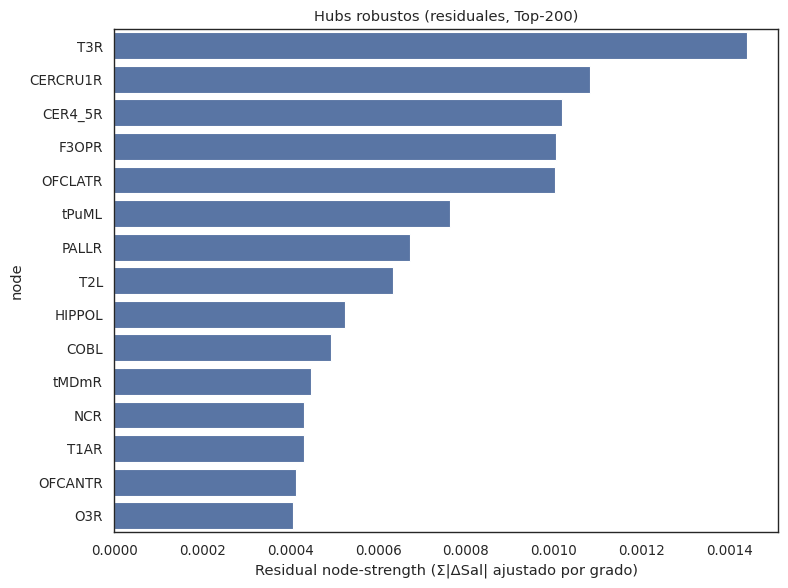

In [6]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, pathlib
RUN_DIR = pathlib.Path('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb')

hubs200 = pd.read_csv(RUN_DIR / 'node_robust_hubs_top200_integrated_gradients_top50.csv')
top = hubs200.sort_values('residual_strength', ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(data=top, x='residual_strength', y='node')
plt.title('Hubs robustos (residuales, Top-200)')
plt.xlabel('Residual node-strength (Σ|ΔSal| ajustado por grado)')
plt.tight_layout(); plt.show()


# Análisis Profundo de Saliencia Diferencial (Fold 1)

Este notebook expande el análisis de interpretabilidad de los resultados del `fold 1` para el clasificador `gb`. Nuestro objetivo es validar la robustez de los hallazgos y profundizar en su significado neurobiológico, siguiendo un plan de análisis riguroso.

## Fundamento Metodológico: Integrated Gradients (IG)

La métrica central de este análisis es la **saliencia diferencial**. Esta se deriva de las atribuciones de características calculadas con *Integrated Gradients*. La función sobre la cual calculamos las atribuciones es la proyección de la salida del encoder del VAE, $\mu(x)$, sobre un vector de pesos discriminativos, $\mathbf{w}$:

$$ f(x) = \mathbf{w}^\top \mu(x) $$

Donde $\mathbf{w}$ se construye a partir de la diferencia de los valores SHAP promedio entre los grupos AD y CN para las características del espacio latente. La atribución de IG para una característica de entrada $x_i$ (es decir, una conexión cerebral) se define como:

$$ \mathrm{IG}_i(x) = (x_i - \tilde{x}_i) \int_{\alpha=0}^{1} \frac{\partial f(\tilde{x} + \alpha(x - \tilde{x}))}{\partial x_i} d\alpha $$

En nuestro caso, usamos una *baseline* (línea de base) nula, $\tilde{x} = \mathbf{0}$. El mapa de saliencia para un grupo se calcula como la media de las magnitudes de estas atribuciones, $| \mathrm{IG}_i(x) |$, para todos los sujetos de ese grupo. Finalmente, el mapa diferencial que analizamos es:

$$ \text{SalienciaDiferencial} = \mathbb{E}_{x \sim \text{AD}}[|\text{IG}(x)|] - \mathbb{E}_{x \sim \text{CN}}[|\text{IG}(x)|] $$

Un valor **positivo (rojo)** indica que una conexión es más saliente para identificar el grupo AD, mientras que un valor **negativo (azul)** indica mayor saliencia para el grupo CN.

Ahora, procedemos a cargar los datos y comenzar el análisis.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# --- Configuración de Estilo para Plots ---
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# --- Cargar el Ranking de Conexiones ---
# Este es nuestro fichero principal de resultados para el Fold 1
try:
    df_edges = pd.read_csv('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv')
    print("Fichero de ranking de conexiones cargado exitosamente.")
    print(f"Total de conexiones analizadas: {len(df_edges)}")
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'ranking_conexiones_ANOTADO_integrated_gradients_top50.csv' esté en el mismo directorio.")
    df_edges = pd.DataFrame() # Crear un DF vacío para que no fallen las celdas siguientes

# --- Mostrar un resumen de los datos ---
if not df_edges.empty:
    print("\nPrimeras 5 conexiones más salientes (por magnitud):")
    display(df_edges.head())

Fichero de ranking de conexiones cargado exitosamente.
Total de conexiones analizadas: 8515

Primeras 5 conexiones más salientes (por magnitud):


,Rank,idx_i,idx_j,Saliency_Score,ROI_i_name,ROI_j_name,src_AAL3_Name,dst_AAL3_Name,src_Macro_Lobe,dst_Macro_Lobe,src_Refined_Network,dst_Refined_Network,src_Yeo17_Network,dst_Yeo17_Network
0,1,31,91,0.002129,OFCLATR,CERCRU1R,OFCLATR,CERCRU1R,Other,Cerebellum,DefaultMode_VentralMedial,Visual_Peripheral,DefaultMode_VentralMedial,Visual_Peripheral
1,2,31,89,0.002114,OFCLATR,T3R,OFCLATR,T3R,Other,Temporal,DefaultMode_VentralMedial,Limbic_A_TempPole,DefaultMode_VentralMedial,Limbic_A_TempPole
2,3,7,23,-0.001692,F3OPR,GRR,F3OPR,GRR,Frontal,Other,Control_A,Limbic_B_OFC,Control_A,Limbic_B_OFC
3,4,97,121,-0.001603,CER4_5R,tPuML,CER4_5R,tPuML,Cerebellum,Subcortical,Visual_Central,Background/NonCortical,Visual_Central,Background/NonCortical
4,5,65,109,-0.001560,GSMR,VER4_5,GSMR,VER4_5,Parietal,Cerebellum,Salience_VentralAttention_A,Visual_Central,Salience_VentralAttention_A,Visual_Central


/tmp/ipykernel_20573/1659533862.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=node_saliency_strength.head(top_n_nodes).values, y=node_saliency_strength.head(top_n_nodes).index, ax=axes[0], palette="viridis")
/tmp/ipykernel_20573/1659533862.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=network_pair_strength.head(top_n_pairs).values, y=pair_labels, ax=axes[1], palette="plasma")


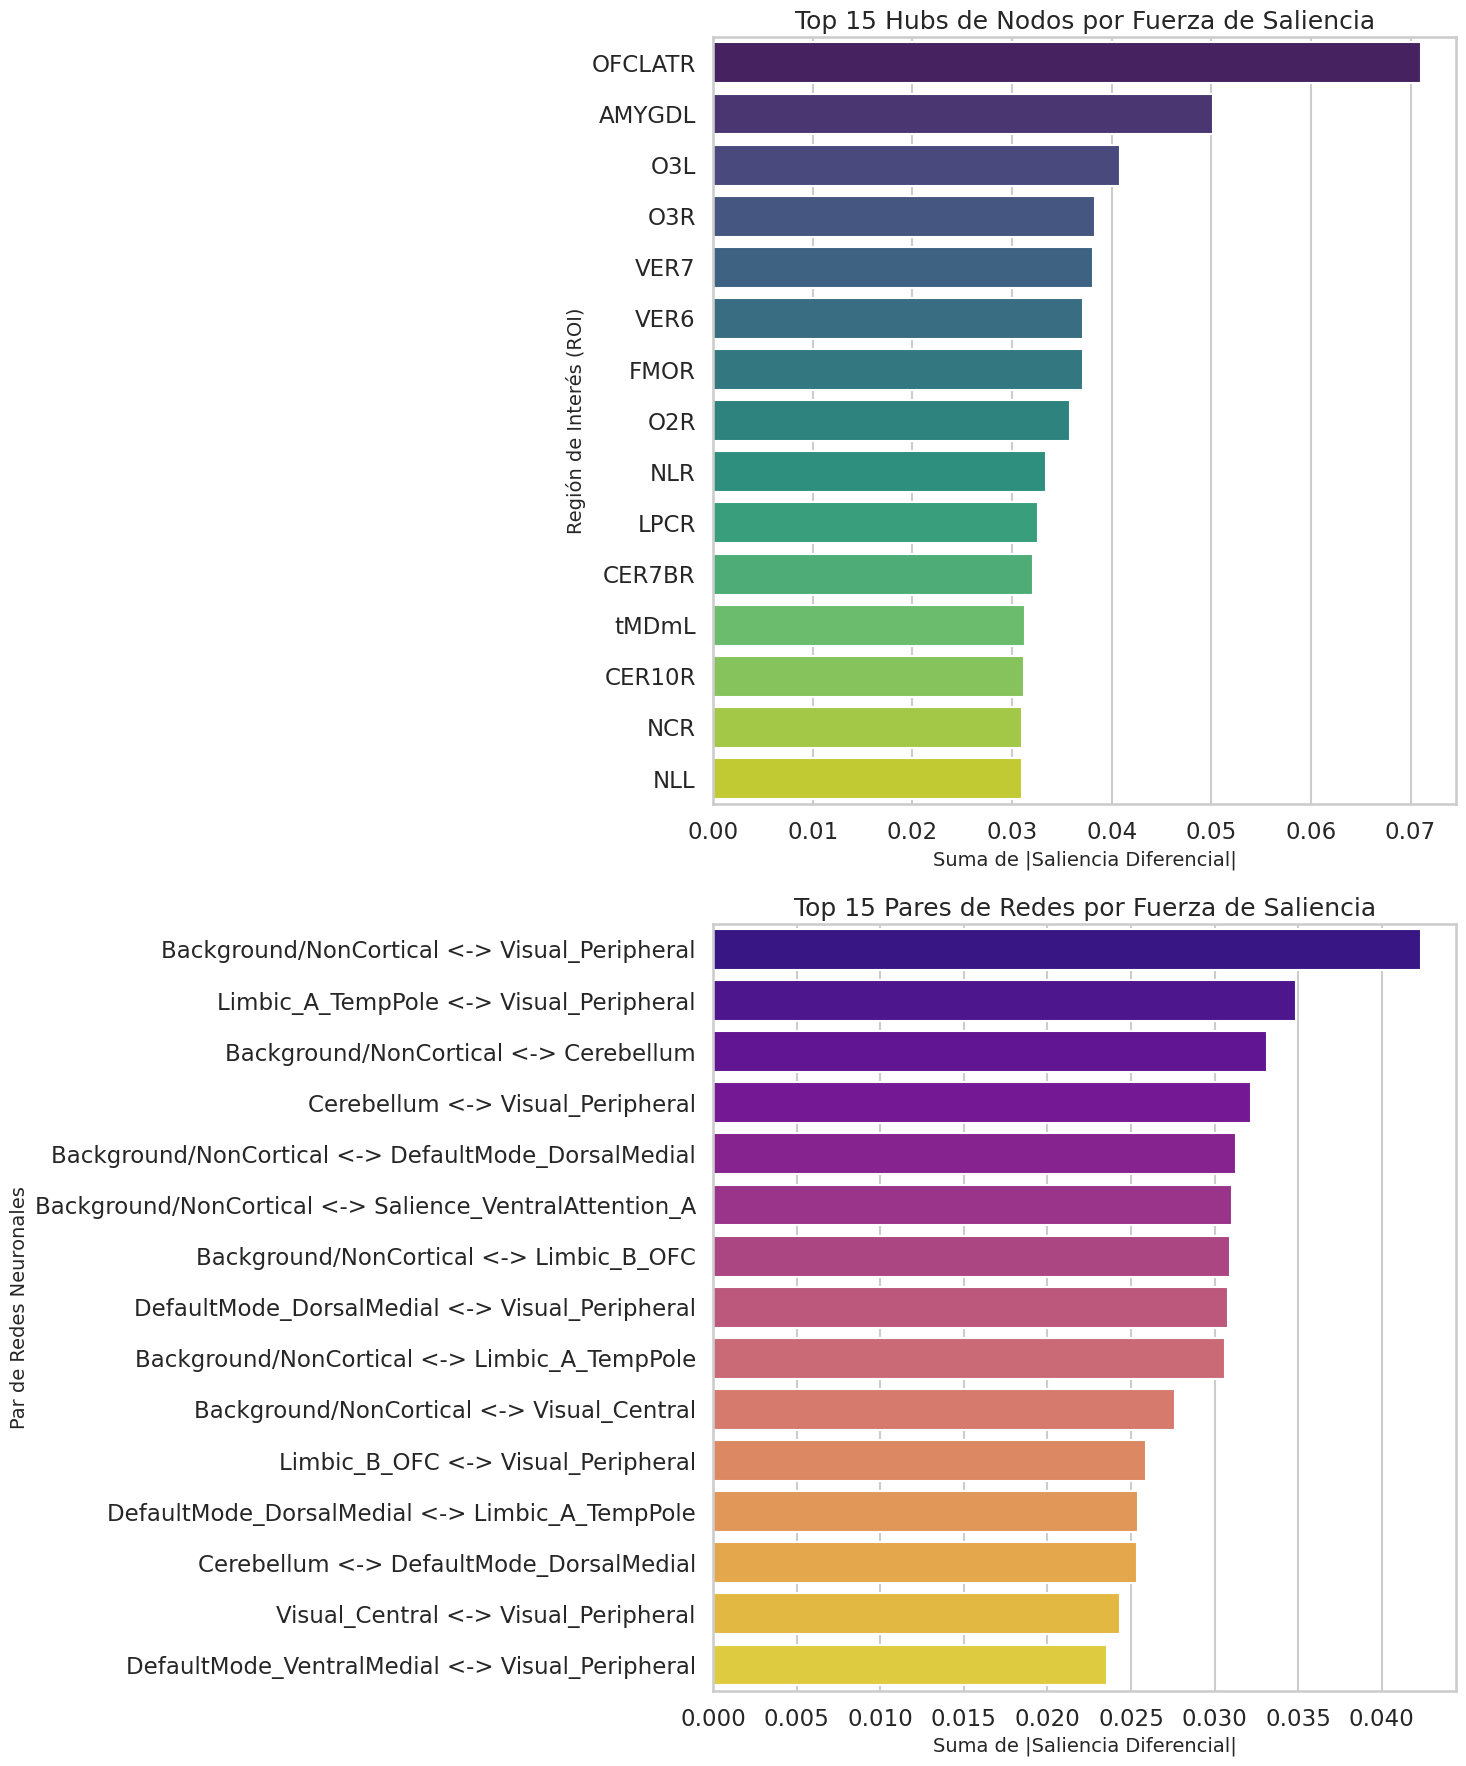


Top 5 Hubs de Nodos:
ROI
OFCLATR    0.071004
AMYGDL     0.050189
O3L        0.040823
O3R        0.038296
VER7       0.038160
Name: Saliency_Score, dtype: float64

Top 5 Pares de Redes:
network_pair
(Background/NonCortical, Visual_Peripheral)           0.042331
(Limbic_A_TempPole, Visual_Peripheral)                0.034894
(Background/NonCortical, Cerebellum)                  0.033134
(Cerebellum, Visual_Peripheral)                       0.032153
(Background/NonCortical, DefaultMode_DorsalMedial)    0.031301
Name: Saliency_Score, dtype: float64


In [8]:
if not df_edges.empty:
    # --- 1. Identificación de Hubs de Nodos ---
    # Para cada conexión (fila), tenemos dos nodos. Usamos melt para tener una lista larga de nodos y su saliencia.
    df_nodes_i = df_edges[['src_AAL3_Name', 'Saliency_Score']].rename(columns={'src_AAL3_Name': 'ROI'})
    df_nodes_j = df_edges[['dst_AAL3_Name', 'Saliency_Score']].rename(columns={'dst_AAL3_Name': 'ROI'})
    
    df_nodes_long = pd.concat([df_nodes_i, df_nodes_j], ignore_index=True)
    
    # Agrupamos por ROI y sumamos la magnitud de la saliencia
    node_saliency_strength = df_nodes_long.groupby('ROI')['Saliency_Score'].apply(lambda x: np.abs(x).sum()).sort_values(ascending=False)
    
    # --- 2. Identificación de Pares de Redes ---
    # Creamos una clave única para cada par de redes para evitar duplicados (p.ej., DMN-Limbic es igual a Limbic-DMN)
    df_edges['network_pair'] = df_edges.apply(
        lambda row: tuple(sorted((row['src_Refined_Network'], row['dst_Refined_Network']))),
        axis=1
    )
    
    network_pair_strength = df_edges.groupby('network_pair')['Saliency_Score'].apply(lambda x: np.abs(x).sum()).sort_values(ascending=False)

    # --- Visualización ---
    fig, axes = plt.subplots(2, 1, figsize=(15, 18))
    
    # Plot de Hubs
    top_n_nodes = 15
    sns.barplot(x=node_saliency_strength.head(top_n_nodes).values, y=node_saliency_strength.head(top_n_nodes).index, ax=axes[0], palette="viridis")
    axes[0].set_title(f'Top {top_n_nodes} Hubs de Nodos por Fuerza de Saliencia')
    axes[0].set_xlabel('Suma de |Saliencia Diferencial|')
    axes[0].set_ylabel('Región de Interés (ROI)')
    
    # Plot de Pares de Redes
    top_n_pairs = 15
    # Formatear las etiquetas para que sean legibles
    pair_labels = [" <-> ".join(map(str, pair)) for pair in network_pair_strength.head(top_n_pairs).index]
    sns.barplot(x=network_pair_strength.head(top_n_pairs).values, y=pair_labels, ax=axes[1], palette="plasma")
    axes[1].set_title(f'Top {top_n_pairs} Pares de Redes por Fuerza de Saliencia')
    axes[1].set_xlabel('Suma de |Saliencia Diferencial|')
    axes[1].set_ylabel('Par de Redes Neuronales')

    plt.tight_layout()
    plt.show()

    print("\nTop 5 Hubs de Nodos:")
    print(node_saliency_strength.head())
    print("\nTop 5 Pares de Redes:")
    print(network_pair_strength.head())

## Saliencia vs. Efecto de Conectividad: ¿Qué Mide Cada Cosa?

Una pregunta fundamental es si la saliencia del modelo simplemente refleja grandes diferencias en la conectividad media entre grupos, o si captura patrones más sutiles (p.ej., diferencias en varianza o interacciones no lineales).

Para investigarlo, calcularemos el **tamaño del efecto de grupo (d de Cohen)** para cada conexión y lo correlacionaremos con la **magnitud de la saliencia**.

-   **d de Cohen:** Mide la diferencia estandarizada de medias entre los grupos AD y CN para la conectividad de un enlace específico. Un |d| alto significa una gran diferencia en la conectividad media.
-   **Magnitud de Saliencia:** Mide cuán *importante* es esa conexión para el modelo, independientemente del valor de conectividad.

Una correlación alta sugeriría que el modelo se fija principalmente en diferencias de medias. Una correlación baja sugeriría que el modelo está usando información más compleja para discriminar.

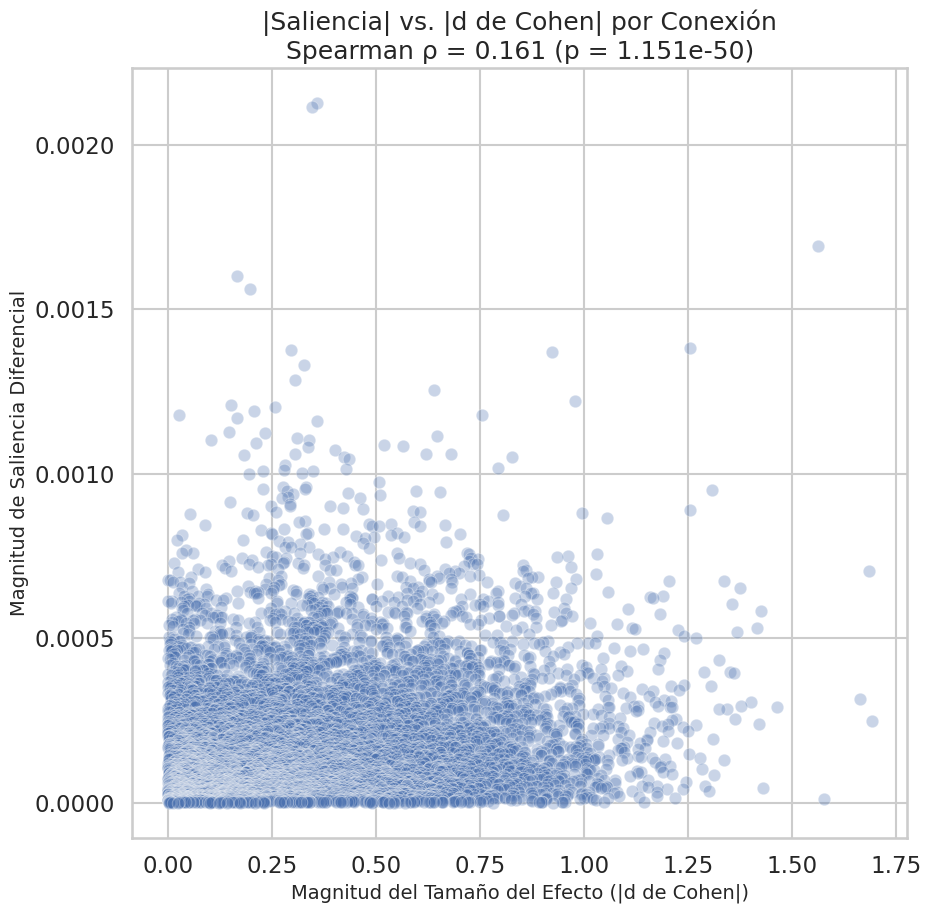

In [9]:
# --- ¡ATENCIÓN! ---
# El siguiente código requiere acceso a los datos originales del tensor de conectividad
# y a los metadatos para separar a los sujetos. Debes asegurarte de que las
# rutas a los archivos .npz, .csv y .npy sean correctas.

# --- Rutas (MODIFICAR SEGÚN SEA NECESARIO) ---
GLOBAL_TENSOR_PATH = '/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv'
RUN_DIR = './resultados67'
FOLD = 1
CHANNELS_TO_USE = [1, 2, 4, 5] # Canales usados en el entrenamiento

# --- Función para calcular d de Cohen ---
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    if pooled_std == 0:
        return 0
    return (np.mean(x) - np.mean(y)) / pooled_std

# --- Cargar datos necesarios ---
try:
    # 1. Cargar tensores y metadatos
    npz_data = np.load(GLOBAL_TENSOR_PATH)
    tensor_all = npz_data['global_tensor_data']
    subj_all_ids = npz_data['subject_ids'].astype(str)
    
    meta_df = pd.read_csv(METADATA_PATH)
    meta_df['SubjectID'] = meta_df['SubjectID'].astype(str).str.strip()

    # 2. Identificar sujetos de test para este fold
    fold_dir = f"{RUN_DIR}/fold_{FOLD}"
    test_indices_in_cnad_df = np.load(f"{fold_dir}/test_indices.npy")
    
    # Recrear el dataframe de sujetos CN/AD para obtener los IDs
    tensor_df = pd.DataFrame({'SubjectID': subj_all_ids, 'tensor_idx': np.arange(len(subj_all_ids))})
    merged = tensor_df.merge(meta_df, on='SubjectID', how='left')
    cnad_df = merged[merged['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
    
    test_df = cnad_df.iloc[test_indices_in_cnad_df]
    
    # 3. Separar tensores de test para AD y CN
    gidx_test_ad = test_df[test_df['ResearchGroup_Mapped'] == 'AD']['tensor_idx'].values
    gidx_test_cn = test_df[test_df['ResearchGroup_Mapped'] == 'CN']['tensor_idx'].values

    # Promediar sobre los canales, ya que la saliencia también se promedió
    tensor_test_ad = tensor_all[gidx_test_ad][:, CHANNELS_TO_USE, :, :].mean(axis=1)
    tensor_test_cn = tensor_all[gidx_test_cn][:, CHANNELS_TO_USE, :, :].mean(axis=1)
    
    # 4. Calcular d de Cohen para cada conexión
    cohen_ds = []
    for _, row in df_edges.iterrows():
        i, j = int(row['idx_i']), int(row['idx_j'])
        conn_ad = tensor_test_ad[:, i, j]
        conn_cn = tensor_test_cn[:, i, j]
        d = cohen_d(conn_ad, conn_cn)
        cohen_ds.append(d)
        
    df_edges['cohen_d'] = cohen_ds
    df_edges['abs_cohen_d'] = np.abs(cohen_ds)
    df_edges['abs_saliency'] = df_edges['Saliency_Score'].abs()

    # 5. Correlación y visualización
    corr, p_value = spearmanr(df_edges['abs_saliency'], df_edges['abs_cohen_d'])

    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df_edges, x='abs_cohen_d', y='abs_saliency', alpha=0.3)
    plt.title(f'|Saliencia| vs. |d de Cohen| por Conexión\nSpearman ρ = {corr:.3f} (p = {p_value:.3e})')
    plt.xlabel('Magnitud del Tamaño del Efecto (|d de Cohen|)')
    plt.ylabel('Magnitud de Saliencia Diferencial')
    plt.show()

except FileNotFoundError as e:
    print(f"No se pudieron cargar los archivos de datos necesarios: {e}")
    print("Omitiendo cálculo de d de Cohen.")

In [10]:
# --- Cargar el mapa de saliencia diferencial completo (contiene todos los canales) ---
try:
    saliency_map_diff = np.load('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/saliency_map_diff_integrated_gradients_top50.npy')
    print(f"Mapa de saliencia diferencial por canal cargado. Shape: {saliency_map_diff.shape}")

    # --- Analizar cada canal ---
    for channel_idx, channel_num in enumerate(CHANNELS_TO_USE):
        print(f"\n--- Análisis para el Canal {channel_num} (índice {channel_idx}) ---")
        
        sal_channel = saliency_map_diff[channel_idx, :, :]
        
        # Recrear el ranking para este canal
        ut_indices = np.triu_indices(sal_channel.shape[0], k=1)
        df_ch = pd.DataFrame({
            'idx_i': ut_indices[0],
            'idx_j': ut_indices[1],
            'Saliency_Score': sal_channel[ut_indices]
        })
        
        # Unir con la info de anotaciones
        df_ch_annotated = df_ch.merge(
            df_edges[['idx_i', 'idx_j', 'src_AAL3_Name', 'dst_AAL3_Name', 'src_Refined_Network', 'dst_Refined_Network']],
            on=['idx_i', 'idx_j']
        )
        df_ch_annotated['abs_saliency'] = df_ch_annotated['Saliency_Score'].abs()
        df_ch_annotated = df_ch_annotated.sort_values('abs_saliency', ascending=False)
        
        print("Top 5 conexiones (AD > CN):")
        display(df_ch_annotated[df_ch_annotated['Saliency_Score'] > 0].head())
        
        print("Top 5 conexiones (CN > AD):")
        display(df_ch_annotated[df_ch_annotated['Saliency_Score'] < 0].head())

except FileNotFoundError:
    print("Error: No se encontró 'saliency_map_diff_integrated_gradients_top50.npy'. Omitiendo análisis por canal.")

Mapa de saliencia diferencial por canal cargado. Shape: (4, 131, 131)

--- Análisis para el Canal 1 (índice 0) ---
Top 5 conexiones (AD > CN):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
3622,31,89,0.002704,OFCLATR,T3R,DefaultMode_VentralMedial,Limbic_A_TempPole,0.002704
5740,56,57,0.002651,FUSIL,FUSIR,Visual_Peripheral,Visual_Peripheral,0.002651
2074,17,18,0.002189,COBR,FML,Limbic_B_OFC,DefaultMode_VentralMedial,0.002189
4622,42,66,0.002159,AMYGDL,GAL,Limbic_A_TempPole,DefaultMode_DorsalMedial,0.002159
7010,75,111,0.002151,NLR,VER7,Salience_VentralAttention_A,Background/NonCortical,0.002151


Top 5 conexiones (CN > AD):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
904,7,23,-0.002833,F3OPR,GRR,Control_A,Limbic_B_OFC,0.002833
7977,97,121,-0.002779,CER4_5R,tPuML,Visual_Central,Background/NonCortical,0.002779
5553,53,95,-0.002199,O2R,CER3R,Visual_Peripheral,DefaultMode_Core,0.002199
6449,66,81,-0.002151,GAL,T1R,DefaultMode_DorsalMedial,DefaultMode_Temp,0.002151
3684,32,53,-0.002090,INL,O2R,Salience_VentralAttention_A,Visual_Peripheral,0.002090



--- Análisis para el Canal 2 (índice 1) ---
Top 5 conexiones (AD > CN):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
2789,23,76,0.002582,GRR,PALLL,Limbic_B_OFC,Basal_Ganglia,0.002582
3622,31,89,0.002403,OFCLATR,T3R,DefaultMode_VentralMedial,Limbic_A_TempPole,0.002403
1399,11,36,0.002350,F3O_2R,CIPL,DefaultMode_VentralMedial,DefaultMode_DorsalMedial,0.002350
1816,14,102,0.002216,SMAL,CER8L,Salience_VentralAttention_A,Cerebellum,0.002216
2950,25,26,0.002156,OFCMEDR,OFCANTL,Limbic_B_OFC,Limbic_B_OFC,0.002156


Top 5 conexiones (CN > AD):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
6905,73,117,-0.002861,NCR,tVPLL,Brainstem_Midbrain,Background/NonCortical,0.002861
2690,22,84,-0.002747,GRL,T2L,Limbic_B_OFC,DefaultMode_VentralMedial,0.002747
3767,33,39,-0.002305,INR,HIPPOR,Salience_VentralAttention_A,Limbic_A_TempPole,0.002305
5998,59,99,-0.002263,PAR,CER6R,Somatomotor_A,Visual_Peripheral,0.002263
7976,97,120,-0.002216,CER4_5R,tMDmR,Visual_Central,Background/NonCortical,0.002216



--- Análisis para el Canal 4 (índice 2) ---
Top 5 conexiones (AD > CN):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
6879,73,91,0.003108,NCR,CERCRU1R,Brainstem_Midbrain,Visual_Peripheral,0.003108
7741,91,98,0.002631,CERCRU1R,CER6L,Visual_Peripheral,Visual_Peripheral,0.002631
3624,31,91,0.002577,OFCLATR,CERCRU1R,DefaultMode_VentralMedial,Visual_Peripheral,0.002577
1414,11,51,0.002574,F3O_2R,O1R,DefaultMode_VentralMedial,Visual_Peripheral,0.002574
6764,71,91,0.002441,LPCR,CERCRU1R,Somatomotor_A,Visual_Peripheral,0.002441


Top 5 conexiones (CN > AD):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
5692,55,83,-0.002447,O3R,T1AR,Visual_Peripheral,Limbic_A_TempPole,0.002447
4545,41,77,-0.002315,PARA_HIPPOR,PALLR,Limbic_A_TempPole,Basal_Ganglia,0.002315
7977,97,121,-0.002278,CER4_5R,tPuML,Visual_Central,Background/NonCortical,0.002278
8009,98,121,-0.002230,CER6L,tPuML,Visual_Peripheral,Background/NonCortical,0.002230
6356,64,117,-0.002133,GSML,tVPLL,Salience_VentralAttention_A,Background/NonCortical,0.002133



--- Análisis para el Canal 5 (índice 3) ---
Top 5 conexiones (AD > CN):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
3598,31,65,0.002915,OFCLATR,GSMR,DefaultMode_VentralMedial,Salience_VentralAttention_A,0.002915
3640,31,107,0.002894,OFCLATR,CER10R,DefaultMode_VentralMedial,Cerebellum,0.002894
3600,31,67,0.002791,OFCLATR,GAR,DefaultMode_VentralMedial,DefaultMode_DorsalMedial,0.002791
3618,31,85,0.002771,OFCLATR,T2R,DefaultMode_VentralMedial,DorsalAttention_A,0.002771
3624,31,91,0.002750,OFCLATR,CERCRU1R,DefaultMode_VentralMedial,Visual_Peripheral,0.002750


Top 5 conexiones (CN > AD):


,idx_i,idx_j,Saliency_Score,src_AAL3_Name,dst_AAL3_Name,src_Refined_Network,dst_Refined_Network,abs_saliency
5541,53,83,-0.002093,O2R,T1AR,Visual_Peripheral,Limbic_A_TempPole,0.002093
5561,53,103,-0.001685,O2R,CER8R,Visual_Peripheral,Cerebellum,0.001685
2577,21,79,-0.001613,FMOR,HESCHLR,DefaultMode_DorsalMedial,Somatomotor_B,0.001613
1850,15,21,-0.001537,SMAR,FMOR,Somatomotor_A,DefaultMode_DorsalMedial,0.001537
5537,53,79,-0.001520,O2R,HESCHLR,Visual_Peripheral,Somatomotor_B,0.001520


In [11]:
%%bash
# Bucle para los folds 2 a 5 (Fold 1 ya lo hiciste)
for fold in {1..5}; do
  echo "--- Procesando Fold $fold ---"

  # 1. Calcular SHAP
  python interpretar_fold_gemini.py shap \
    --run_dir ./resultados67 --fold $fold --clf gb \
    --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz \
    --metadata_path /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv \
    --channels_to_use 1 2 4 5 \
    --latent_dim 48 \
    --latent_features_type mu \
    --metadata_features Age Sex Manufacturer \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.25 \
    --use_layernorm_vae_fc \
    --intermediate_fc_dim_vae half \
    --vae_final_activation linear \
    --gn_num_groups 16

  # 2. Generar Saliencia
  python interpretar_fold_gemini.py saliency \
    --run_dir ./resultados67 --fold $fold --clf gb \
    --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz \
    --metadata_path /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv \
    --roi_annotation_path /home/diego/Escritorio/limpio/roi_info_master.csv \
    --roi_order_path /home/diego/Escritorio/limpio/roi_order_131.npy \
    --channels_to_use 1 2 4 5 \
    --latent_dim 48 \
    --top_k 50 \
    --shap_weight_mode ad_vs_cn_diff \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.25 \
    --use_layernorm_vae_fc \
    --intermediate_fc_dim_vae half \
    --vae_final_activation linear \
    --gn_num_groups 16 \
    --num_conv_layers_encoder 4

done

echo "✅ ¡Análisis de interpretabilidad para todos los folds completado!"


--- Procesando Fold 1 ---


[INFO] [SHAP] fold=1 clf=gb
[INFO] [SHAP] Cargando datos de background CRUDOS desde: shap_background_raw_gb.joblib
[INFO] [SHAP] X_raw shape=(37, 51) (latentes + 3 metadatos)
[INFO] [SHAP] Background DataFrame detectado pero columnas no coinciden; transformando…
[INFO] [SHAP] Pack guardado: resultados67/fold_1/interpretability_shap/shap_pack_gb.joblib
[INFO] [SALIENCY] fold=1 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx    weight  importance           feature
         28  0.184933    0.000214 latent__latent_28
          8 -0.135120   -0.000157  latent__latent_8
         46  0.113080    0.000131 latent__latent_46
          5  0.063333    0.000073  latent__latent_5
         33  0.062660    0.000073 latent__latent_33
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando

--- Procesando Fold 2 ---


[INFO] [SHAP] fold=2 clf=gb
[INFO] [SHAP] Cargando datos de background CRUDOS desde: shap_background_raw_gb.joblib
[INFO] [SHAP] X_raw shape=(37, 51) (latentes + 3 metadatos)
[INFO] [SHAP] Background DataFrame detectado pero columnas no coinciden; transformando…
[INFO] [SHAP] Pack guardado: resultados67/fold_2/interpretability_shap/shap_pack_gb.joblib
[INFO] [SALIENCY] fold=2 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx    weight  importance           feature
         37  0.578543    0.209530 latent__latent_37
         34  0.080638    0.029205 latent__latent_34
         38 -0.034804   -0.012605 latent__latent_38
          4  0.033227    0.012034  latent__latent_4
         24  0.026640    0.009648 latent__latent_24
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando

--- Procesando Fold 3 ---


[INFO] [SHAP] fold=3 clf=gb
[INFO] [SHAP] Cargando datos de background CRUDOS desde: shap_background_raw_gb.joblib
[INFO] [SHAP] X_raw shape=(37, 51) (latentes + 3 metadatos)
[INFO] [SHAP] Background DataFrame detectado pero columnas no coinciden; transformando…
[INFO] [SHAP] Pack guardado: resultados67/fold_3/interpretability_shap/shap_pack_gb.joblib
[INFO] [SALIENCY] fold=3 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx   weight  importance           feature
         28 0.171470    0.000048 latent__latent_28
          5 0.168046    0.000047  latent__latent_5
         38 0.137003    0.000038 latent__latent_38
         24 0.070234    0.000019 latent__latent_24
          4 0.046859    0.000013  latent__latent_4
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando métod

--- Procesando Fold 4 ---


[INFO] [SHAP] fold=4 clf=gb
[INFO] [SHAP] Cargando datos de background CRUDOS desde: shap_background_raw_gb.joblib
[INFO] [SHAP] X_raw shape=(37, 51) (latentes + 3 metadatos)
[INFO] [SHAP] Background DataFrame detectado pero columnas no coinciden; transformando…
[INFO] [SHAP] Pack guardado: resultados67/fold_4/interpretability_shap/shap_pack_gb.joblib
[INFO] [SALIENCY] fold=4 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx   weight  importance           feature
         45 0.542941    0.000070 latent__latent_45
         26 0.106223    0.000014 latent__latent_26
         32 0.057619    0.000007 latent__latent_32
          4 0.055620    0.000007  latent__latent_4
         14 0.048716    0.000006 latent__latent_14
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando métod

--- Procesando Fold 5 ---


[INFO] [SHAP] fold=5 clf=gb
[INFO] [SHAP] Cargando datos de background CRUDOS desde: shap_background_raw_gb.joblib
[INFO] [SHAP] X_raw shape=(36, 51) (latentes + 3 metadatos)
[INFO] [SHAP] Background DataFrame detectado pero columnas no coinciden; transformando…
[INFO] [SHAP] Pack guardado: resultados67/fold_5/interpretability_shap/shap_pack_gb.joblib
[INFO] [SALIENCY] fold=5 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx    weight  importance           feature
         14  0.187563    0.001028 latent__latent_14
         43 -0.136566   -0.000748 latent__latent_43
         38  0.110211    0.000604 latent__latent_38
         17  0.061534    0.000337 latent__latent_17
          2  0.050350    0.000276  latent__latent_2
[INFO] [SALIENCY] Sujetos AD=19  CN=17
[INFO] [SALIENCY] Usando

✅ ¡Análisis de interpretabilidad para todos los folds completado!


In [12]:
# CELDA 1 ─── imports y paths
import json, glob, numpy as np, scipy.stats as st
from skimage.metrics import adapted_rand_error as dice   # 1–ARE ≈ Dice
RUN_DIR = "./resultados67"
SAL_MAPS = sorted(glob.glob(f"{RUN_DIR}/fold_*/interpretability_gb/saliency_map_diff_top50.npy"))
assert len(SAL_MAPS) == 5, f"Faltan mapas: {SAL_MAPS}"


In [13]:
# CELDA 2 ─── grand average + métricas
diff_maps = [np.load(p) for p in SAL_MAPS]                 # list len=5, shape (C,R,R)
diff_avg  = np.mean(diff_maps, axis=0).astype(np.float32)  # (C,R,R)
np.save(f"{RUN_DIR}/grand_average_saliency.npy", diff_avg)

# vector upper-triangular por fold (promedio sobre canales)
vecs = [m.mean(axis=0)[np.triu_indices(m.shape[-1],1)] for m in diff_maps]
# Pearson ρ y Dice inter-fold
n     = len(vecs)
rhos  = [st.pearsonr(vecs[i], vecs[j])[0]        for i in range(n) for j in range(i+1,n)]
dices = [1-dice(vecs[i]>0, vecs[j]>0)[0]         for i in range(n) for j in range(i+1,n)]

stats = {
    "rho_mean":        float(np.mean(rhos)),   "rho_std":   float(np.std(rhos)),
    "dice_mean":       float(np.mean(dices)),  "dice_std":  float(np.std(dices)),
    "sign_agreement":  float(np.mean([(v1>0)==(v2>0) for i,v1 in enumerate(vecs) for v2 in vecs[i+1:]]))
}
json.dump(stats, open(f"{RUN_DIR}/saliency_stats.json","w"), indent=2)
stats


{'rho_mean': 0.0033769081346690655,
 'rho_std': 0.030671704560518265,
 'dice_mean': 0.7009152056734095,
 'dice_std': 0.01835161649747756,
 'sign_agreement': 0.4967234292425132}

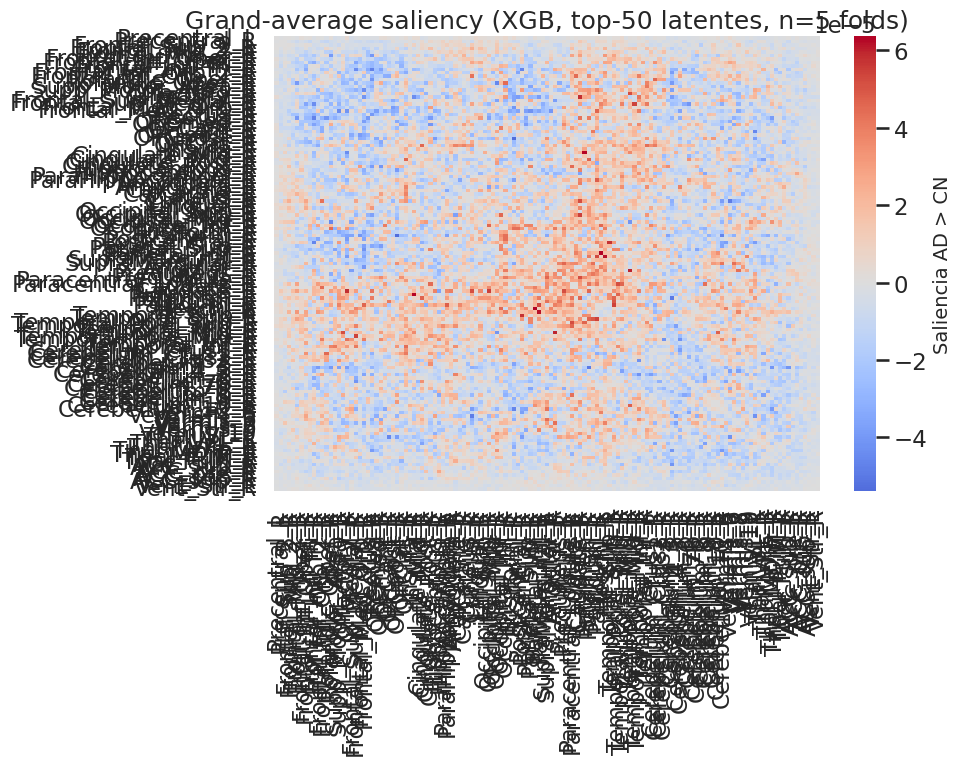

In [14]:
# CELDA 3 ─── heat-map del patrón medio (opcional figura para el paper)
import seaborn as sns, matplotlib.pyplot as plt
roi_names = np.load("/home/diego/Escritorio/limpio/roi_order_131.npy")
plt.figure(figsize=(10,8))
sns.heatmap(diff_avg.mean(axis=0), cmap="coolwarm", center=0,
            xticklabels=roi_names, yticklabels=roi_names,
            cbar_kws=dict(label="Saliencia AD > CN"))
plt.title("Grand-average saliency (XGB, top-50 latentes, n=5 folds)")
plt.tight_layout(); plt.savefig(f"{RUN_DIR}/grand_average_heatmap.png", dpi=300)
plt.show()


In [15]:
# (imports)
import glob, pandas as pd, numpy as np, scipy.stats as st

RUN_DIR = "./resultados67"
# CORRECCIÓN AQUÍ: Cambia 'xgb' por 'gb'
csv_paths = sorted(
    glob.glob(f"{RUN_DIR}/fold_*/interpretability_gb/"
              "ranking_conexiones_ANOTADO_top50.csv"))

# (el resto del código de la celda permanece igual)
dfs = []
for fold, path in enumerate(csv_paths, 1):
    df = (pd.read_csv(path)
            .assign(fold=fold)
            .rename(columns={'Saliency_Score': 'score'}))
    df['edge_id'] = (df[['src_AAL3_Name', 'dst_AAL3_Name']]
                     .apply(lambda r: ' — '.join(sorted(r)), axis=1))
    dfs.append(df[['edge_id', 'score', 'fold']])
all_edges = pd.concat(dfs, ignore_index=True)

print(f"✅ Se cargaron los rankings de {len(csv_paths)} folds.")


✅ Se cargaron los rankings de 5 folds.


In [16]:
def ci95(series):
    """IC95 % bilateral para n<=30 usando t de Student."""
    n = series.size
    m = series.mean()
    s = series.std(ddof=1)
    t_crit = st.t.ppf(0.975, df=n-1)
    half_width = t_crit * s / np.sqrt(n)
    return pd.Series({'mean': m, 'ci_low': m-half_width, 'ci_high': m+half_width})

edge_stats = (all_edges
              .groupby('edge_id')['score']
              .apply(ci95)        # devuelve Serie con índice 'mean', 'ci_low', …
              .unstack()          # pasa ese índice a columnas
              .reset_index())     # deja 'edge_id' como columna normal


# ordenamos por |media| y nos quedamos con los 10 primeros
top10 = (edge_stats
         .assign(abs_mean=lambda d: d['mean'].abs())
         .sort_values('abs_mean', ascending=False)
         .head(10)
         .drop(columns='abs_mean'))


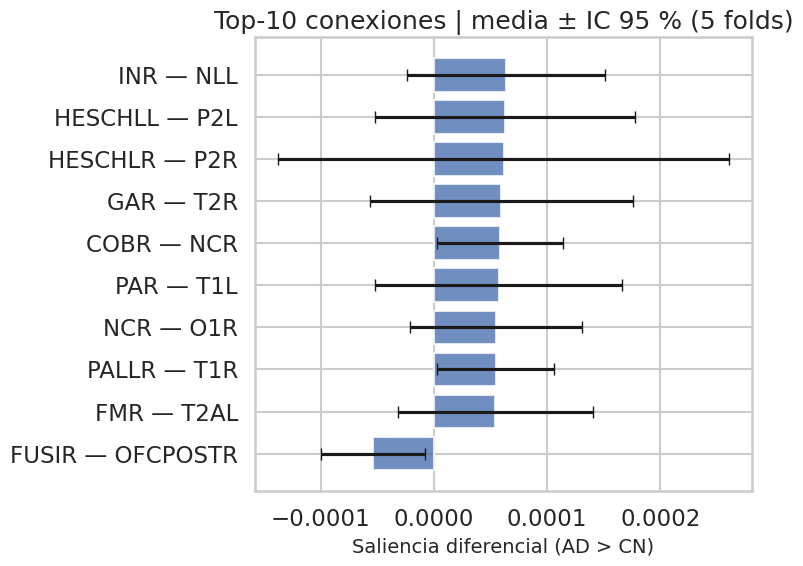

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

y = np.arange(len(top10))[::-1]            # barras horizontales (de arriba abajo)
plt.barh(y,  top10['mean'], xerr=[top10['mean']-top10['ci_low'],
                                  top10['ci_high']-top10['mean']],
         alpha=0.8, capsize=4)

plt.yticks(y, top10['edge_id'])
plt.xlabel('Saliencia diferencial (AD > CN)')
plt.title('Top-10 conexiones | media ± IC 95 % (5 folds)')
plt.tight_layout()
plt.savefig(f"{RUN_DIR}/fig_top10_edges_ic95.png", dpi=300)
plt.show()


In [18]:
top10.to_csv(f"{RUN_DIR}/top10_edges_ic95.csv", index=False)


In [19]:
import numpy as np
sal = np.load("/home/diego/Escritorio/limpio/resultados67/grand_average_saliency.npy")        # shape (C, R, R)
print("Shape de la saliencia:", sal.shape)
w_r = sal.mean(0).sum(axis=0) + sal.mean(0).sum(axis=1)  # col + row
w_r = np.abs(w_r); w_r /= w_r.sum()                # normaliza
np.save("roi_weights.npy", w_r)
print("Pesos de las ROIs guardados en 'roi_weights.npy'.")


Shape de la saliencia: (4, 131, 131)
Pesos de las ROIs guardados en 'roi_weights.npy'.


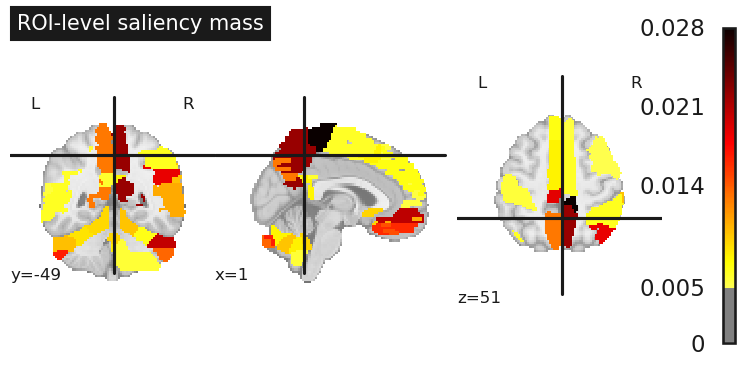

In [20]:
import numpy as np
import nibabel as nib
from nilearn import plotting

# --- 1. Carga el atlas volumétrico ya reordenado ---
atlas_nii = nib.load("/home/diego/Escritorio/limpio/AAL3v1.nii.gz")        # mismo que usaste para parcellar
atlas_data = atlas_nii.get_fdata().astype(int)        # (x,y,z)

# --- 2. Vector de pesos por ROI ---
w_r = np.load("roi_weights.npy")                      # shape = (131,)

# --- 3. Construye un volumen con los pesos ---
roi_weight_vol = np.zeros_like(atlas_data, dtype=float)
for roi_idx, weight in enumerate(w_r, start=1):       # AAL etiquetas empiezan en 1
    roi_weight_vol[atlas_data == roi_idx] = weight

roi_weight_img = nib.Nifti1Image(roi_weight_vol, atlas_nii.affine, atlas_nii.header)

# --- 4. Dibuja ---
plotting.plot_stat_map(
    roi_weight_img,
    threshold=0.005,          # ajusta si quieres dejar fuera valores pequeños
    display_mode="ortho",     # 'x', 'y', 'z', etc.
    cmap="hot_r",
    colorbar=True,
    title="ROI-level saliency mass"
)


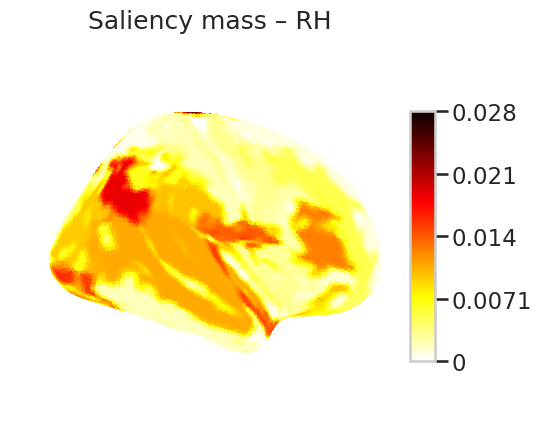

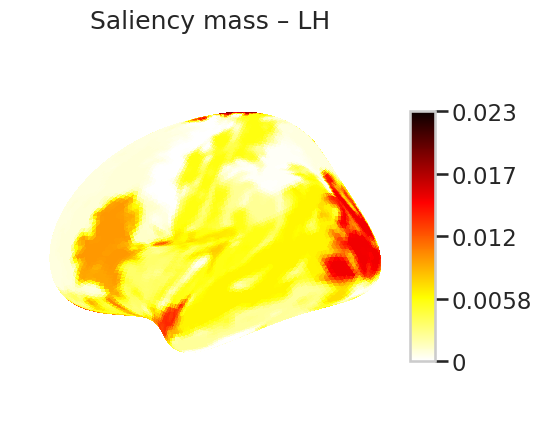

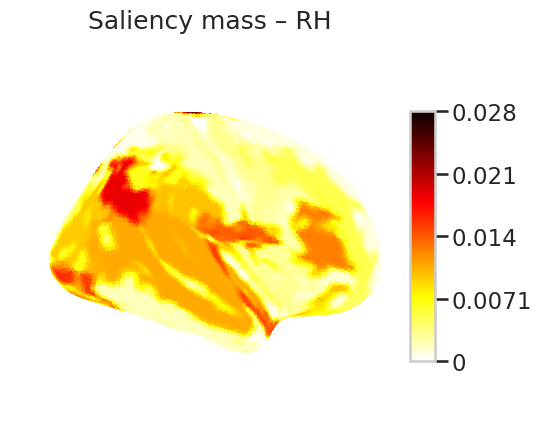

In [21]:
import numpy as np
import nibabel as nib
from nilearn import surface, plotting, datasets

# ---- 1. Volumen con pesos (como antes) ----
#roi_weight_img = nib.load("roi_weight_img.nii.gz")    # o crea con el bucle anterior

# ---- 2. Mallas fsaverage ----
fsavg = datasets.fetch_surf_fsaverage('fsaverage5')
# fsavg.infl_left  / fsavg.infl_right  → mallas infladas

texture_lh = surface.vol_to_surf(roi_weight_img, fsavg.pial_left)
texture_rh = surface.vol_to_surf(roi_weight_img, fsavg.pial_right)

# ---- 3. Pinta cada hemisferio ----
plotting.plot_surf_stat_map(
    surf_mesh=fsavg.infl_left,
    stat_map=texture_lh,
    hemi='left',
    colorbar=True, cmap='hot_r',
    title='Saliency mass – LH'
)

plotting.plot_surf_stat_map(
    surf_mesh=fsavg.infl_right,
    stat_map=texture_rh,
    hemi='right',
    colorbar=True, cmap='hot_r',
    title='Saliency mass – RH'
)

